<h1 style="font-family: Trebuchet MS; font-size: 14px; color: #720026; text-align: right; ">Matthew Liew</h1>
<h1><br><span style="color: #720026;; font-size: 30px"><b>Entrix: Case Study Challenge</b></span><br></h1>

<a id="0"></a>
<p style="background-color:#ff7f51;font-family:Trebuchet MS;font-weight:bold;color:#FFFFFF ;font-size:40px;text-align:center;border-radius:100px 100px">Question 1</p>



In [1]:
# load necessary packages

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import data_utils as du
import plotters
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.utils.statistics import (
    check_seasonality, plot_acf, plot_pacf, remove_seasonality,remove_trend,
    stationarity_test_adf
)   
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.model_selection import train_test_split
import os
from meteostat import Point, Hourly
import holidays
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from forecast_utils import ARIMAWrapper, XGBWrapper
import yfinance as yf
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from prophet import Prophet



In [2]:
# load data set

day_price_df = pd.read_csv('./data/Day-ahead_Prices_60min.csv')

# split the date column into start and end time, we will use start time only
day_price_df[['start_time', 'end_time']] = day_price_df['MTU (CET/CEST)']\
                                                .str.split(' - ', expand=True)

# drops unnecessary columns
day_price_df.drop(columns=['MTU (CET/CEST)', 'BZN|DE-LU', 'Currency', 'end_time']
                , inplace=True) # assumes all currency same in same region

day_price_df.rename(columns={
    'Day-ahead Price [EUR/MWh]': 'price'
}, inplace=True)

day_price_df['start_time'] = pd.to_datetime(day_price_df['start_time'],
                                            format='%d.%m.%Y %H:%M')
day_price_ts = day_price_df.set_index('start_time') 

px.line(day_price_ts, title='Day-Ahead Price Time Series (EUR/MWh) - hourly')

<a id="0"></a>

# <h1 style="font-family: Trebuchet MS; font-size: 25px; color: #da627d; text-align: left; "><b>Data Cleaning</b></h1>

In this section, we'll focus on data cleaning, specifically checking for any NaN values. If any are found, we'll examine the corresponding dates and determine whether we can fill the missing value using interpolation, back fill or front fill.

In [3]:
idx_nan = day_price_df['price'].isna()
print(f"There exists {idx_nan.sum()} missing values")

# prints missing value with 5 rows before and after
day_price_df[idx_nan]
missing_row = du.show_nrows_around_target(day_price_df, 'price')
missing_row = pd.DataFrame(missing_row).set_index('start_time')
px.line(missing_row, title="Shows missing value(s)")

There exists 1 missing values


We identified one missing value occurring at 2AM CET. Given the time, it's unlikely to be an outlier or exhibit extreme variation, so it's reasonable to interpolate this value.


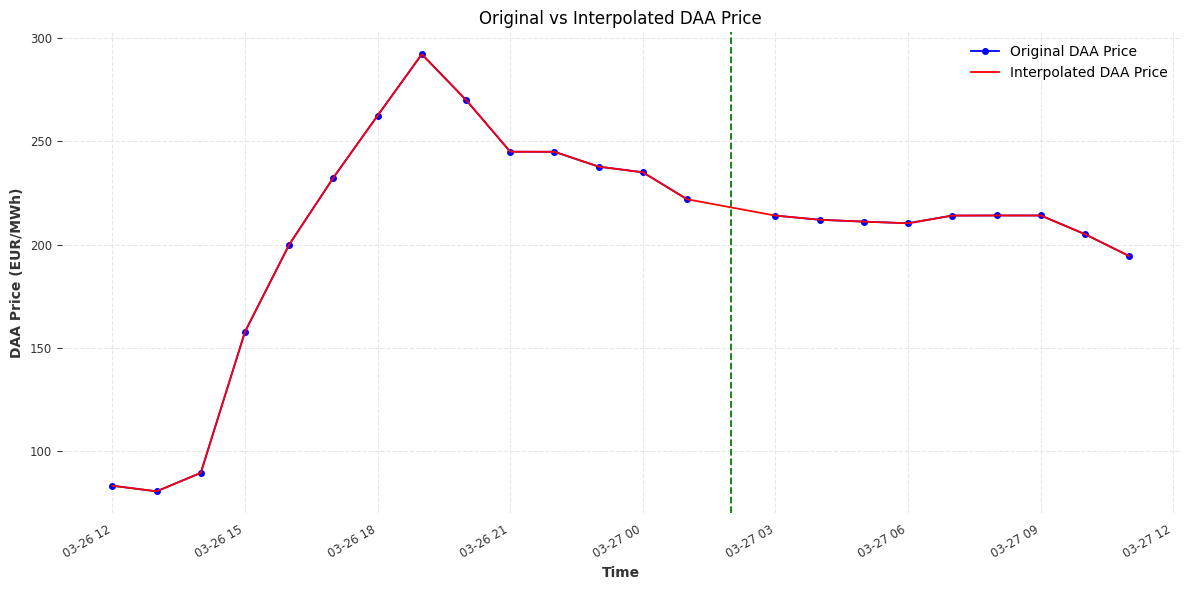

In [4]:
day_price_ts['price_interpolated'] = day_price_ts['price'].interpolate(method='time')

# Analysis
start_date = datetime(2022, 3, 26, 12)
end_date = datetime(2022, 3, 27, 12)
filtered_data = day_price_ts[['price', 'price_interpolated']].loc[
    (day_price_ts.index >= start_date) & (day_price_ts.index < end_date)
]
plt.figure(figsize=(12, 6))
plt.plot(filtered_data.index, filtered_data['price'], 'b-o', label='Original DAA Price', markersize=4)
plt.plot(filtered_data.index, filtered_data['price_interpolated'], 'r-', label='Interpolated DAA Price')
plt.title('Original vs Interpolated DAA Price')
plt.xlabel('Time')
plt.ylabel('DAA Price (EUR/MWh)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

vertical_line_time = datetime(2022, 3, 27, 2)  # Time for the vertical line
plt.axvline(x=vertical_line_time, color='green', linestyle='--', label='02:00')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show();

In [5]:
# replaces interpolated price with original price
day_price_ts['price'] = day_price_ts['price_interpolated']
day_price_ts.drop(columns=['price_interpolated'], inplace=True)
day_price_ts.head()

,price
start_time,
2022-01-01 00:00:00,50.05
2022-01-01 01:00:00,41.33
2022-01-01 02:00:00,43.22
2022-01-01 03:00:00,45.46
2022-01-01 04:00:00,37.67


<a id="0"></a>

# <h1 style="font-family: Trebuchet MS; font-size: 25px; color: #da627d; text-align: left; "><b>Preliminary Analysis</b></h1>

Now that we have a complete time series dataset, we can perform a preliminary analysis to inspect the time series data

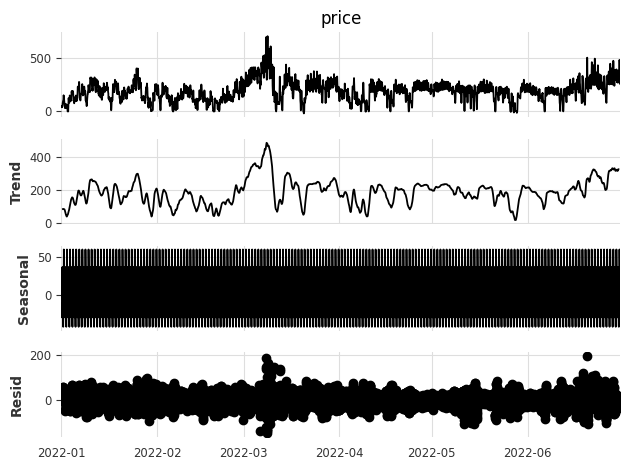

In [6]:
# Seasonal decomposition

seasonal_decompose(day_price_ts['price']).plot()
plt.show()

The seasonal decomposition of the price time series reveals a clear upward trend with a noticeable disturbance around early March 2022, this is likely caused by **Russia invasion of Ukraine**. Furthermore, towards the end, there appears to be slight upward trend.

The seasonal component shows regular periodic behavior, likely due to daily or hourly cycles. 

The residuals remain relatively stable throughout most of the period, there is increased variability and notable outliers around the same March period, aligning with the observed spike.

This suggests that perhaps one may use ARIMA or ETS to model the time series.

<a id="0"></a>
<p style="background-color:#720026;font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">ARIMA</p>

#TODO

Stationarity test for whole series with 0 lag:
Reject the null hypothesis. The series is likely stationary.

Train-Test split at 2022-06-01 00:00:00
Stationarity test for train series with 0 lag:
Reject the null hypothesis. The series is likely stationary.



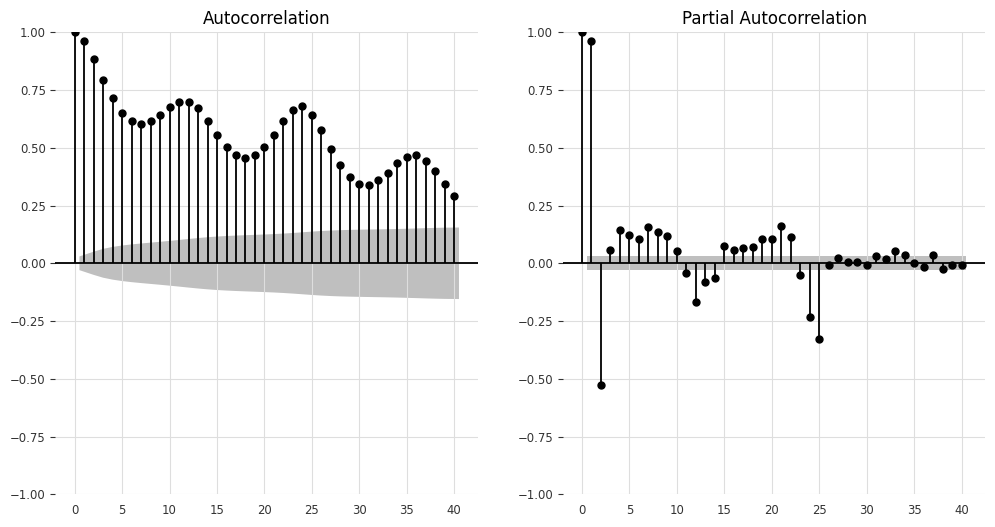

In [7]:
split_date = datetime(2022, 6, 1)
arima_obj = ARIMAWrapper(day_price_ts, split_date)
arima_obj.plot_acf_pacf()

### Next,

we find the best (p,d,q) parameters for ARIMA using the training data. We do this by traversing (p,d,q) with different integers and get the one with the smalles AIC value.

In [8]:
# %%capture 
# p,d,q = arima_obj.get_best_ARIMA_params()
# print(f"Best params obtain: ARIMA({p}, {d}, {q})")

# # Best params obtain: ARIMA(5, 1, 3)

In [9]:
arima_obj.run_ARIMA(5, 1, 3)
arima_obj.get_forecast()
arima_obj.plot_forecast()
arima_obj.get_mae_rmse()

--------------------------------
Running ARIMA(5, 1, 3) on train set


/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum 

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 3625
Model:                 ARIMA(5, 1, 3)   Log Likelihood              -15734.424
Date:                Fri, 16 May 2025   AIC                          31486.848
Time:                        15:29:18   BIC                          31542.606
Sample:                    01-01-2022   HQIC                         31506.712
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0839      0.088     12.258      0.000       0.911       1.257
ar.L2          0.3083      0.180      1.715      0.086      -0.044       0.661
ar.L3         -1.1098      0.145     -7.635      0.0

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



RSME for ARIMA(5, 1, 3): 80.8668
MAE for ARIMA(5, 1, 3): 65.1303


### Note

From the analysis above, it is clear that ARIMA is not able to forecast too far in advance. Therefore, a smart thing to do is to shorten the forecast period as well as the start datetime of the training set.

In the following, we only want to forecast **24 H** on the day of 30. June 2022 and we take the training from 60 days prior for training.

Stationarity test for whole series with 0 lag:
Reject the null hypothesis. The series is likely stationary.

Train-Test split at 2022-06-30 00:00:00
Stationarity test for train series with 0 lag:
Reject the null hypothesis. The series is likely stationary.



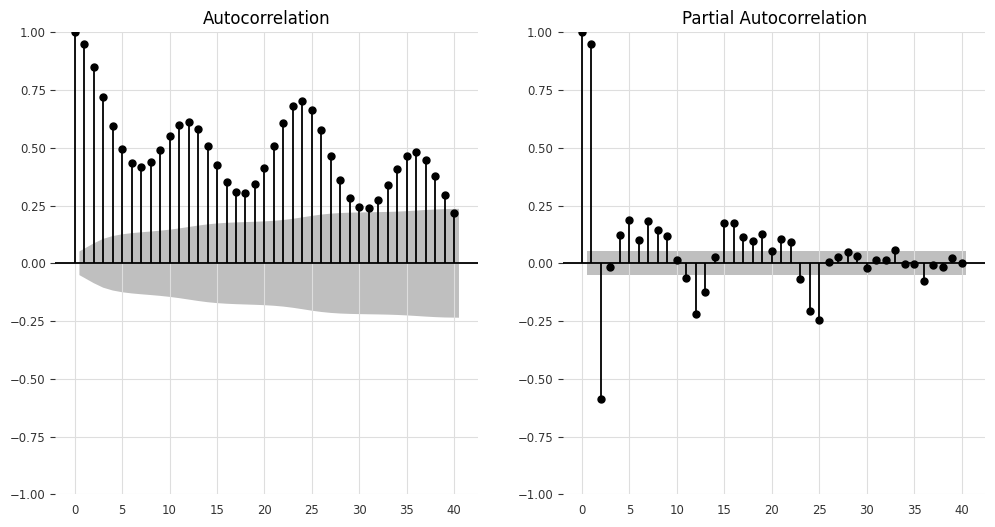

In [10]:
split_date = datetime(2022, 6, 30, 0) 
start_slice = split_date - timedelta(days=60) 

short_arima = ARIMAWrapper(day_price_ts, split_date, start_date_slice=start_slice)
short_arima.plot_acf_pacf()

In [11]:
# check stationary test for one lag

ts_short = TimeSeries.from_dataframe(short_arima.ts)
ts_train_short = TimeSeries.from_dataframe(short_arima.ts_train)

print(stationarity_test_adf(ts_short, 1))
print("--"*20)
print(stationarity_test_adf(ts_train_short, 1))

# So we should take d = 1

(np.float64(-11.776987237936437), np.float64(1.0567109835875369e-21), 1, 1462, {'1%': np.float64(-3.4348307241414218), '5%': np.float64(-2.863518943068048), '10%': np.float64(-2.5678235713684194)}, np.float64(12884.767319220511))
----------------------------------------
(np.float64(-11.656248292310417), np.float64(1.9822383057517335e-21), 1, 1439, {'1%': np.float64(-3.4349024693573584), '5%': np.float64(-2.8635506057382325), '10%': np.float64(-2.5678404322793846)}, np.float64(12651.263925766365))


In [12]:
# %%capture 
# p,d,q = short_arima.get_best_ARIMA_params()

# print(f"Best params obtain: ARIMA({p}, {d}, {q})")

# # Best params obtain: ARIMA(3, 1, 4)

In [13]:
short_arima.run_ARIMA(3, 1, 4)
short_arima.get_forecast()
short_arima.plot_forecast()
short_arima.get_mae_rmse()

--------------------------------
Running ARIMA(3, 1, 4) on train set


/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 1441
Model:                 ARIMA(3, 1, 4)   Log Likelihood               -6150.529
Date:                Fri, 16 May 2025   AIC                          12317.057
Time:                        15:29:21   BIC                          12359.236
Sample:                    05-01-2022   HQIC                         12332.803
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7484      0.097      7.743      0.000       0.559       0.938
ar.L2          0.7030      0.167      4.203      0.000       0.375       1.031
ar.L3         -0.9829      0.096    -10.187      0.0

/Users/matthewliew/projects/entrix_assessment/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



RSME for ARIMA(3, 1, 4): 39.0132
MAE for ARIMA(3, 1, 4): 30.2889


#### Backtesting (not implemented, no time)

<a id="0"></a>
<p style="background-color:#720026;font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Prophet</p>

give overview here #TODO

<a id="0"></a>
<p style="background-color:#720026;font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">XGBoost</p>

give overview here #TODO

<a id="0"></a>

## <span style="color: #F8766D;">**Feature Selection**</span>


We loaded an hourly time-series with DAA price per MWh. We start feature engineering by separating the the datetime into its atomic metrics, i.e. month of the year, week of the year, day of the week, and the hour of day. On top of that, we will also extract boolean features such as is_weekend, is_holiday.

We will do this by calling `add_date_features()` function. 

In [14]:
xgb_day_price_ts = du.add_date_features(day_price_ts.copy())

xgb_day_price_ts.head()

,price,is_weekend,datetime,hour,dayofweek,quarter,year,dayofyear,dayofmonth,month,weekofyear,is_holiday
start_time,,,,,,,,,,,,
2022-01-01 00:00:00,50.05,True,2022-01-01 00:00:00,0,5,1,2022,1,1,1,52,False
2022-01-01 01:00:00,41.33,True,2022-01-01 01:00:00,1,5,1,2022,1,1,1,52,False
2022-01-01 02:00:00,43.22,True,2022-01-01 02:00:00,2,5,1,2022,1,1,1,52,False
2022-01-01 03:00:00,45.46,True,2022-01-01 03:00:00,3,5,1,2022,1,1,1,52,False
2022-01-01 04:00:00,37.67,True,2022-01-01 04:00:00,4,5,1,2022,1,1,1,52,False


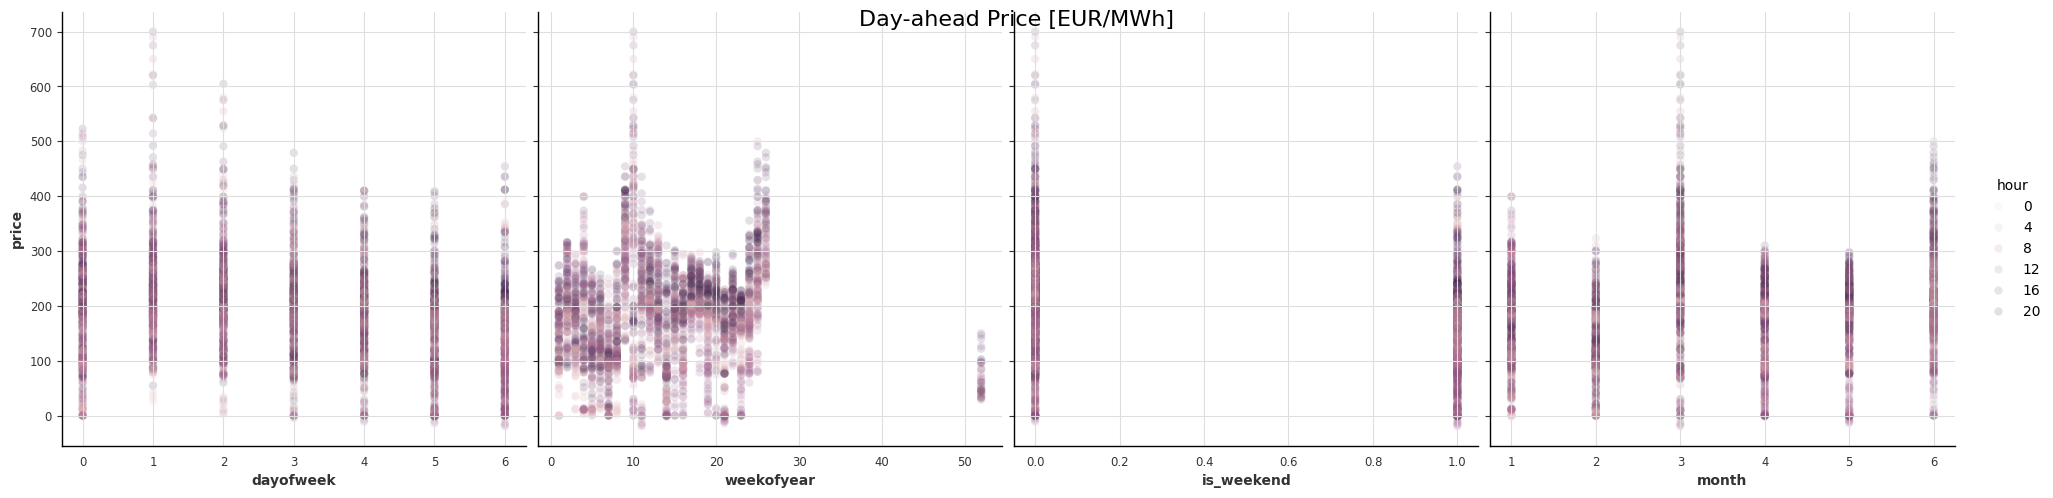

In [15]:
sns.pairplot(xgb_day_price_ts,
            hue='hour',
            x_vars=['dayofweek','weekofyear', 'is_weekend', 'month'],
            y_vars='price',
            height=5,
            plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Day-ahead Price [EUR/MWh]', fontsize=16)
plt.show()

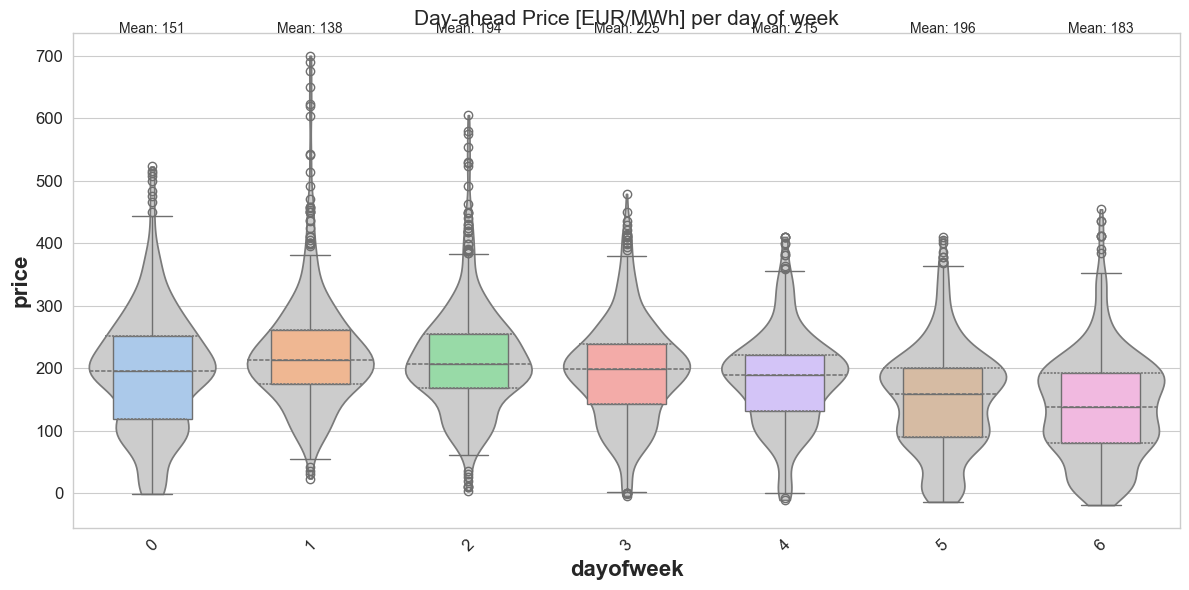

In [16]:
plotters.plot_violin_ts(xgb_day_price_ts, 'dayofweek', 'price', 'Day-ahead Price [EUR/MWh] per day of week')

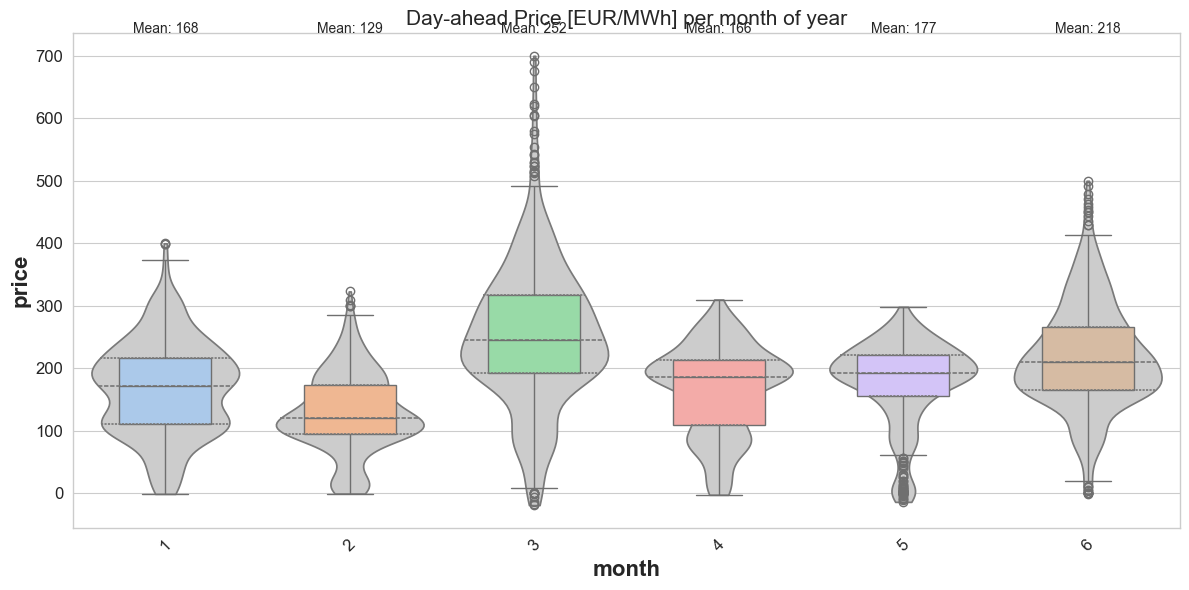

In [17]:
plotters.plot_violin_ts(xgb_day_price_ts, 'month', 'price', 'Day-ahead Price [EUR/MWh] per month of year')

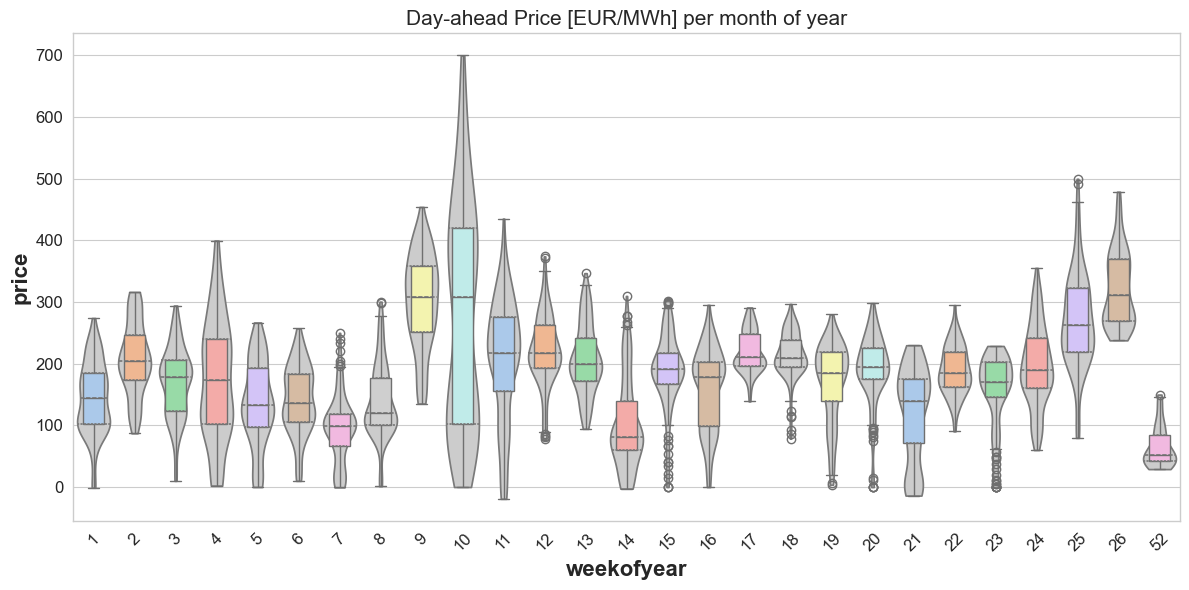

In [18]:
plotters.plot_violin_ts(xgb_day_price_ts, 'weekofyear', 'price', 'Day-ahead Price [EUR/MWh] per month of year', False)

### <span style="color: #F8766D;">**Weather Data**</span>

bla bla

In [19]:
locations = {
    'LU': (49.815273, 6.129583),  # Luxembourg City coordinates
    'DE': (52.520008, 13.404954)  # Berlin coordinates (as an example for Germany)
}
weather_data = du.add_locations_weather(xgb_day_price_ts, locations)

xgb_merged_data = xgb_day_price_ts.merge(weather_data[['temp', 'tsun']], left_index=True, right_index=True, how='left')

xgb_merged_data.head()

,price,is_weekend,datetime,hour,dayofweek,quarter,year,dayofyear,dayofmonth,month,weekofyear,is_holiday,temp,tsun
start_time,,,,,,,,,,,,,,
2022-01-01 00:00:00,50.05,True,2022-01-01 00:00:00,0,5,1,2022,1,1,1,52,False,11.9,0.0
2022-01-01 01:00:00,41.33,True,2022-01-01 01:00:00,1,5,1,2022,1,1,1,52,False,11.9,0.0
2022-01-01 02:00:00,43.22,True,2022-01-01 02:00:00,2,5,1,2022,1,1,1,52,False,11.9,0.0
2022-01-01 03:00:00,45.46,True,2022-01-01 03:00:00,3,5,1,2022,1,1,1,52,False,11.9,0.0
2022-01-01 04:00:00,37.67,True,2022-01-01 04:00:00,4,5,1,2022,1,1,1,52,False,11.8,0.0


### <span style="color: #F8766D;">**How to capture economic sentiment?**</span>

bla bla

In [20]:
indices = ['^VIX', '^GDAXI', 'EURUSD=X']

vix_close = yf.download('^VIX', start=xgb_merged_data.index.min(), end=xgb_merged_data.index.max())['Open']
dax_close = yf.download('^GDAXI', start=xgb_merged_data.index.min(), end=xgb_merged_data.index.max())['Open']
eur_usd_close = yf.download("EURUSD=X", start=xgb_merged_data.index.min(), end=xgb_merged_data.index.max())['Open']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [21]:
xgb_merged_data.head()

,price,is_weekend,datetime,hour,dayofweek,quarter,year,dayofyear,dayofmonth,month,weekofyear,is_holiday,temp,tsun
start_time,,,,,,,,,,,,,,
2022-01-01 00:00:00,50.05,True,2022-01-01 00:00:00,0,5,1,2022,1,1,1,52,False,11.9,0.0
2022-01-01 01:00:00,41.33,True,2022-01-01 01:00:00,1,5,1,2022,1,1,1,52,False,11.9,0.0
2022-01-01 02:00:00,43.22,True,2022-01-01 02:00:00,2,5,1,2022,1,1,1,52,False,11.9,0.0
2022-01-01 03:00:00,45.46,True,2022-01-01 03:00:00,3,5,1,2022,1,1,1,52,False,11.9,0.0
2022-01-01 04:00:00,37.67,True,2022-01-01 04:00:00,4,5,1,2022,1,1,1,52,False,11.8,0.0


In [22]:
xgb_merged_data['date'] = xgb_merged_data['datetime'].dt.date

vix_close['date'] = vix_close.index.date
dax_close['date'] = dax_close.index.date
eur_usd_close['date'] = eur_usd_close.index.date

xgb_merged_data = xgb_merged_data.merge(
                                vix_close[['date', '^VIX']], 
                                on='date', 
                                how='left'
                                )

xgb_merged_data = xgb_merged_data.merge(
                                dax_close[['date', '^GDAXI']], 
                                on='date', 
                                how='left'
                                )

xgb_merged_data = xgb_merged_data.merge(
                                eur_usd_close[['date', 'EURUSD=X']], 
                                on='date', 
                                how='left'
                                )

xgb_merged_data.set_index(xgb_merged_data['date'], inplace=True)

xgb_merged_data = xgb_merged_data.rename(
                                        columns={'^VIX': 'VIX',
                                        '^GDAXI': 'DAX',
                                        'EURUSD=X': 'EURUSD'}
                                        )


xgb_merged_data.drop(['date'], axis=1, inplace=True)
xgb_merged_data = xgb_merged_data.set_index(xgb_merged_data['datetime'])
xgb_merged_data

,price,is_weekend,datetime,hour,dayofweek,quarter,year,dayofyear,dayofmonth,month,weekofyear,is_holiday,temp,tsun,VIX,DAX,EURUSD
datetime,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,50.05,True,2022-01-01 00:00:00,0,5,1,2022,1,1,1,52,False,11.9,0.0,NaN,NaN,NaN
2022-01-01 01:00:00,41.33,True,2022-01-01 01:00:00,1,5,1,2022,1,1,1,52,False,11.9,0.0,NaN,NaN,NaN
2022-01-01 02:00:00,43.22,True,2022-01-01 02:00:00,2,5,1,2022,1,1,1,52,False,11.9,0.0,NaN,NaN,NaN
2022-01-01 03:00:00,45.46,True,2022-01-01 03:00:00,3,5,1,2022,1,1,1,52,False,11.9,0.0,NaN,NaN,NaN
2022-01-01 04:00:00,37.67,True,2022-01-01 04:00:00,4,5,1,2022,1,1,1,52,False,11.8,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 19:00:00,479.00,False,2022-06-30 19:00:00,19,3,2,2022,181,30,6,26,False,25.7,49.0,29.42,12795.219727,1.044659
2022-06-30 20:00:00,450.00,False,2022-06-30 20:00:00,20,3,2,2022,181,30,6,26,False,24.4,0.0,29.42,12795.219727,1.044659
2022-06-30 21:00:00,394.21,False,2022-06-30 21:00:00,21,3,2,2022,181,30,6,26,False,23.4,0.0,29.42,12795.219727,1.044659


In [23]:
plotters.plot_compare_two_col(xgb_merged_data, 'price', 'VIX', 'Day-ahead Price [EUR/MWh] vs VIX')

In [24]:
plotters.plot_compare_two_col(xgb_merged_data, 'price', 'DAX', 'Day-ahead Price [EUR/MWh] vs DAX')

In [25]:
plotters.plot_compare_two_col(xgb_merged_data, 'price', 'EURUSD', 'Day-ahead Price [EUR/MWh] vs VIX')

### <span style="color: #F8766D;">**Energy Market**</span>

bla bla

In [26]:
df_load = pd.read_csv('./data/Forecasted_consumption_202201010000_202207010000_Hour.csv',
                        delimiter=';', parse_dates=['Start date', 'End date'])

df_load = df_load.drop(columns=['End date'])
df_load = df_load.rename(columns={'grid load [MWh] Calculated resolutions': 'grid_load',
                                    'Residual load [MWh] Calculated resolutions': 'residual_load',})

df_load['grid_load'].loc[df_load['grid_load']=='-'] = np.nan
df_load['grid_load'] = df_load['grid_load'].str.replace(',', '').astype(float)

df_load['residual_load'].loc[df_load['residual_load']=='-'] = np.nan
df_load['residual_load'] = df_load['residual_load'].str.replace(',', '').astype(float)

df_load = df_load.set_index('Start date')

/var/folders/bj/vqft4btx31x4b208qdl7q1nm0000gn/T/ipykernel_70595/4075160306.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/var/folders/bj/vqft4btx31x4b208qdl7q1nm0000gn/T/ipykernel_70595/4075160306.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/bj/vqft4btx31x4b208qdl7q1nm0000gn/T/ipykernel_70595/4075160306.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
df_DH_generation = pd.read_csv('./data/Forecasted_generation_Day-Ahead_202201010000_202207010000_Hour.csv',
                        delimiter=';', parse_dates=['Start date', 'End date'])

df_DH_generation = df_DH_generation.set_index('Start date')
df_DH_generation= df_DH_generation[['Total [MWh] Original resolutions']]
df_DH_generation = df_DH_generation.rename(columns={'Total [MWh] Original resolutions': 'total_DH_generation'})
df_DH_generation['total_DH_generation'] = df_DH_generation['total_DH_generation']\
                                            .str.replace(',', '').astype(float)

/var/folders/bj/vqft4btx31x4b208qdl7q1nm0000gn/T/ipykernel_70595/55072728.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [28]:
xgb_merged_data = xgb_merged_data.join(df_load, how='left')
xgb_merged_data = xgb_merged_data.join(df_DH_generation, how='left')

xgb_merged_data['energy_balance'] = xgb_merged_data['total_DH_generation'] - xgb_merged_data['grid_load']

In [29]:
xgb_merged_data

,price,is_weekend,datetime,hour,dayofweek,quarter,year,dayofyear,dayofmonth,month,...,is_holiday,temp,tsun,VIX,DAX,EURUSD,grid_load,residual_load,total_DH_generation,energy_balance
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,50.05,True,2022-01-01 00:00:00,0,5,1,2022,1,1,1,...,False,11.9,0.0,NaN,NaN,NaN,42310.25,10779.50,52473.0,10162.75
2022-01-01 01:00:00,41.33,True,2022-01-01 01:00:00,1,5,1,2022,1,1,1,...,False,11.9,0.0,NaN,NaN,NaN,40419.00,9956.50,50246.0,9827.00
2022-01-01 02:00:00,43.22,True,2022-01-01 02:00:00,2,5,1,2022,1,1,1,...,False,11.9,0.0,NaN,NaN,NaN,39095.75,10040.50,49656.0,10560.25
2022-01-01 03:00:00,45.46,True,2022-01-01 03:00:00,3,5,1,2022,1,1,1,...,False,11.9,0.0,NaN,NaN,NaN,38066.50,10459.00,47619.0,9552.50
2022-01-01 04:00:00,37.67,True,2022-01-01 04:00:00,4,5,1,2022,1,1,1,...,False,11.8,0.0,NaN,NaN,NaN,38188.25,11932.75,45778.0,7589.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 19:00:00,479.00,False,2022-06-30 19:00:00,19,3,2,2022,181,30,6,...,False,25.7,49.0,29.42,12795.219727,1.044659,59783.75,49921.50,56068.0,-3715.75
2022-06-30 20:00:00,450.00,False,2022-06-30 20:00:00,20,3,2,2022,181,30,6,...,False,24.4,0.0,29.42,12795.219727,1.044659,57877.50,49577.75,54533.0,-3344.50
2022-06-30 21:00:00,394.21,False,2022-06-30 21:00:00,21,3,2,2022,181,30,6,...,False,23.4,0.0,29.42,12795.219727,1.044659,55824.50,46520.75,53595.0,-2229.50


### Covariance Matrices

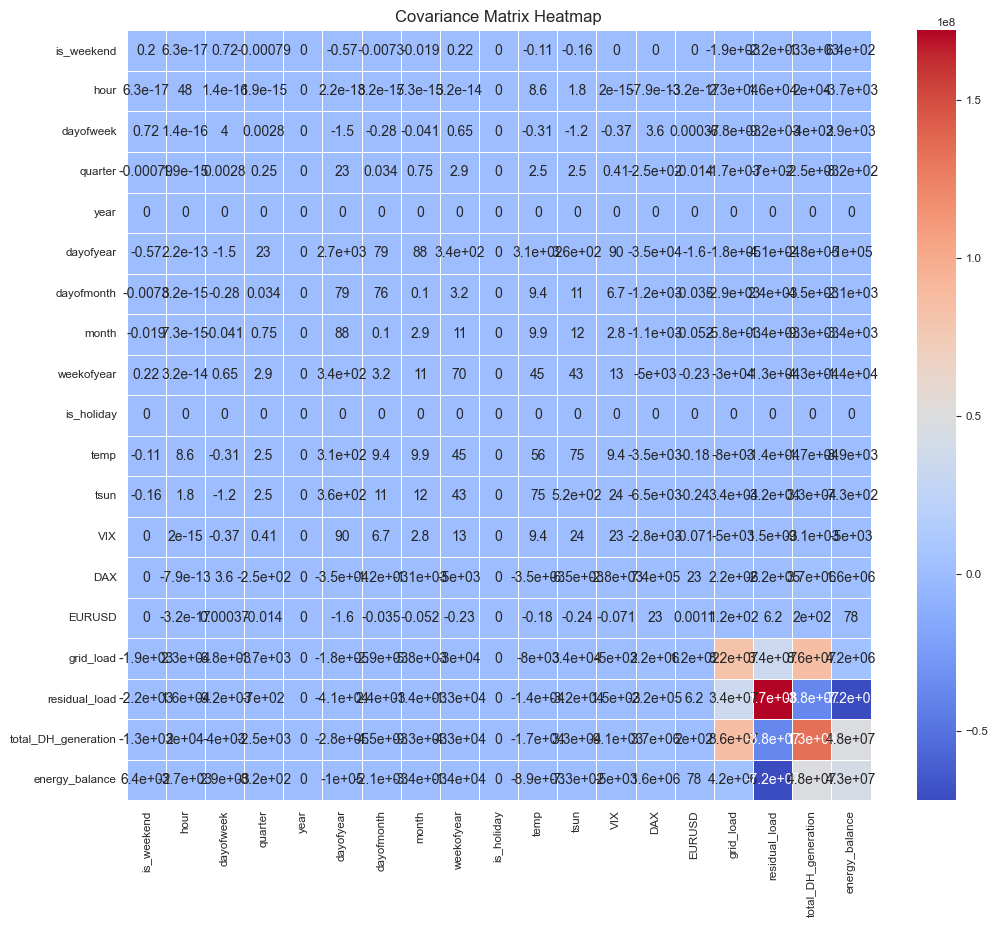

In [30]:
plt.figure(figsize=(12, 10))
sns.heatmap(
            xgb_merged_data.reset_index(drop=True).drop(
                ['price', 'datetime'],
                axis=1
                ).cov(),
            annot=True,
            cmap='coolwarm',
            linewidths=0.5
            )
plt.title('Covariance Matrix Heatmap')
plt.show()

In [31]:
drop_col = [
            # 'price_ma_3d',
            # 'temp',
            # 'EURUSD',
            # 'quarter',
            # 'is_weekend',
            # 'is_holiday',
            ]

cleaned_merged_data = xgb_merged_data.copy().drop(drop_col, axis=1)


In [32]:
split_date = datetime(2022, 5, 1)
xgb_obj = XGBWrapper(cleaned_merged_data, split_point=split_date)

Train-Test split at 2022-05-01 00:00:00


In [33]:
xgb_obj.add_lagged_MA_price(4)

Adding 1-lagged hour of price to X_train and X_test
Adding mean of previous 2 hours of price to X_train and X_test
Adding mean of previous 3 hours of price to X_train and X_test
Adding mean of previous 4 hours of price to X_train and X_test


XGBoost model fitted.


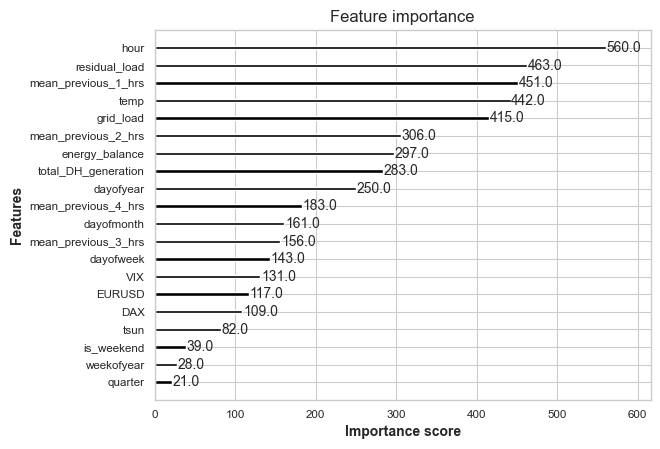

In [34]:
xgb_obj.run_xgb()
xgb_obj.plot_importance

In [35]:
xgb_obj.get_forecast()
xgb_obj.plot_forecast()
xgb_obj.get_mae_rmse

RSME for XGBoost: 21.1355
MAE for XGBoost: 15.1652


In [36]:
xgb_rsme_24H, xgb_made_24H = du.get_rmse_mae(
                                xgb_obj.y_test[-24:],
                                xgb_obj.get_forecast_df['price_prediction'][-24:]
                                )

print(f"RMSE for XGBoost last 24 H: {xgb_rsme_24H}")
print(f"MAE for XGBoost last 24 H: {xgb_made_24H}")

RMSE for XGBoost last 24 H: 30.662
MAE for XGBoost last 24 H: 25.059


<a id="0"></a>
<p style="background-color:#720026;font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Prophet</p>

give overview here #TODO